<a href="https://colab.research.google.com/github/sdlm/pytorch_mnist/blob/master/generate_bg_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random

import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug import parameters as iap

from tqdm import tqdm_notebook, tqdm

In [0]:
mask_pool_size = 100
flat_bg_pool_size = 100
bg_admix_iters = 3

In [0]:
def get_flat_background(h_size=256, w_size=256):
    original_smpl = np.empty((h_size, w_size, 3), dtype=np.uint8)
    original_smpl.fill(128)
    aug = iaa.Add(
        iap.Normal(0, 45), 
        per_channel=1
    )
    smpl = aug.augment_image(original_smpl)
    np.clip(smpl, 0, 255, out=smpl)
    return smpl

def get_mask(h_size=256, w_size=256):
  white_bg = np.empty((h_size, w_size, 3), dtype=np.uint8)
  white_bg.fill(255)
  aug = iaa.Sequential([
      iaa.CoarseDropout(
          iap.Positive(iap.Normal(0, 0.2)), 
          size_percent=iap.Positive(iap.Normal(0, 0.1)) + 0.01
      ),
      iaa.GaussianBlur(
          sigma=iap.Positive(iap.Normal(0, 5)) + 1
      ),
      iaa.PiecewiseAffine(
          scale=iap.Positive(iap.Normal(0, 0.0333)) + 0.001
      )
  ])
  mask = aug.augment_image(white_bg)
  np.clip(mask, 0, 255, out=mask)
  return mask

In [4]:
mask_pool = [get_mask() for _ in tqdm(range(mask_pool_size))]

100%|██████████| 100/100 [00:12<00:00,  7.67it/s]


In [5]:
flat_bg_pool = [get_flat_background() for _ in tqdm(range(flat_bg_pool_size))]

100%|██████████| 100/100 [00:00<00:00, 1019.68it/s]


In [0]:
def _admix_by_rand_mask_img(orig: np.ndarray):
    # prepare mask
    coef = max(iap.Normal(4, 1).draw_sample(), 0.5)
    mask = random.choice(mask_pool) / 255.0 * coef
    np.clip(mask, 0, 1, out=mask)
    
    # admix mono background
    addition = random.choice(flat_bg_pool) / 255.0
    merge = (1.0 - mask) * orig / 255.0 + mask * addition
    
    # 
    np.clip(merge, 0, 255, out=merge)
    return np.array(merge * 255.0, dtype=np.uint8)

def admix_by_rand_mask_img(orig: np.ndarray, iter_count: int = 1):
    for _ in range(iter_count):
        orig = _admix_by_rand_mask_img(orig)
      
    aug = iaa.Add(
        iap.Normal(0, 35), 
        per_channel=1
    )
    orig = aug.augment_image(orig)
    np.clip(orig, 0, 255, out=orig)
    return orig

def generate_rand_bg():
    back = get_flat_background()
    return admix_by_rand_mask_img(back, bg_admix_iters)

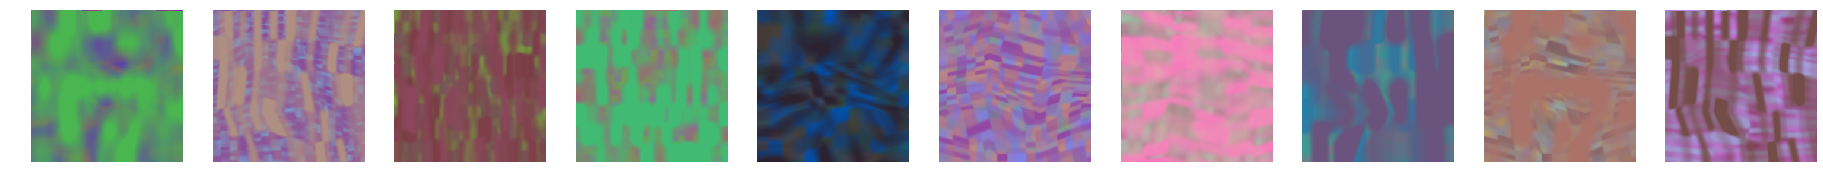

In [7]:
images = [
    generate_rand_bg()
    for _ in range(10)
]
fig, axes = plt.subplots(1, len(images), figsize=(32, 16))
for i, image in enumerate(images):
    axes[i].set_axis_off()
    axes[i].imshow(image);